# **Библиотеки**

Установка PyYAML и Darts

In [1]:
!pip install pyyaml==5.4.1
!pip install darts

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


Импорт и вывод версии Darts

In [2]:
import darts

Установка Optuna для оптимизации гиперпараметров

In [3]:
!pip install -U optuna==2.0.0

Импорт основных библиотек

In [8]:
import numpy as np
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
import sklearn
from sklearn import preprocessing

Импорт компонентов из библиотеки Darts

In [6]:
!pip install --upgrade darts

  Using cached darts-0.31.0-py3-none-any.whl.metadata (52 kB)
Using cached darts-0.31.0-py3-none-any.whl (934 kB)
  Attempting uninstall: darts
    Found existing installation: darts 0.22.0
    Uninstalling darts-0.22.0:
      Successfully uninstalled darts-0.22.0


In [1]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import LightGBMModel, CatBoostModel, Prophet, RNNModel, TFTModel, NaiveSeasonal, ExponentialSmoothing, NHiTSModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.metrics import mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Импорт компонентов Optuna для оптимизации

In [2]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import plot_optimization_history, plot_contour, plot_param_importances

Импорт EarlyStopping для предотвращения переобучения

In [3]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

Настройка отображения графиков в Jupyter Notebook

In [4]:
%matplotlib inline

Установка семян для воспроизводимости результатов

In [6]:
import torch
import numpy as np

torch.manual_seed(1)
np.random.seed(1)


# **Данные**

## Предобработка данных

In [11]:
!unzip -q /content/drive/MyDrive/train.csv.zip

replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y


In [12]:
!unzip -q /content/drive/MyDrive/transactions.csv.zip

replace transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [9]:
# считываем все данные
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/holidays_events.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/oil.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/stores.csv')
df_transactions = pd.read_csv('/content/transactions.csv')

Этот код выполняет несколько важных шагов в подготовке данных для прогнозирования продаж:

1. Подготовка и объединение данных о продажах с информацией о магазинах.
2. Создание временных рядов для каждого семейства продуктов и магазина.
3. Применение различных трансформаций к данным, включая заполнение пропусков, кодирование категориальных переменных, логарифмическое преобразование и масштабирование.
4. Вычисление скользящих средних продаж для каждого временного ряда.
5. Создание дополнительных временных признаков (год, месяц, день недели и т.д.).
6. Подготовка и трансформация общих ковариат.

In [10]:
# Подготовка данных о продажах (целевая переменная)

# Получение уникальных значений семейств продуктов и номеров магазинов
family_list = df_train['family'].unique()
store_list = df_stores['store_nbr'].unique()

# Объединение данных о продажах с информацией о магазинах
train_merged = pd.merge(df_train, df_stores, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
# Преобразование типов данных в строковые для последующей обработки
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

# Подготовка тестовых данных
df_test_dropped = df_test.drop(['onpromotion'], axis=1)
df_test_sorted = df_test_dropped.sort_values(by=['store_nbr','family'])

# Создание объектов TimeSeries (Darts) и организация их в словарь по семействам продуктов

family_TS_dict = {}

for family in family_list:
  df_family = train_merged.loc[train_merged['family'] == family]

  # Создание временных рядов для каждого семейства продуктов
  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                static_cols=["city","state","type","cluster"],
                                value_cols="sales",
                                fill_missing_dates=True,
                                freq='D')
  # Преобразование типа данных в float32 для оптимизации памяти
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  # Сортировка временных рядов по номеру магазина
  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[family] = list_of_TS_family

# Трансформация данных о продажах

family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  # Создание пайплайна для обработки данных
  train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])

  # Применение пайплайна к данным
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  family_pipeline_dict[key] = train_pipeline
  family_TS_transformed_dict[key] = training_transformed

# Создание объектов TimeSeries (Darts) для всех данных

list_of_TS = TimeSeries.from_group_dataframe(
                                train_merged,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                static_cols=["city","state","type","cluster"],
                                value_cols="sales",
                                fill_missing_dates=True,
                                freq='D')
for ts in list_of_TS:
            ts = ts.astype(np.float32)

list_of_TS = sorted(list_of_TS, key=lambda ts: int(ts.static_covariates_values()[0,0]))

# Трансформация всех данных о продажах

train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])

training_transformed = train_pipeline.fit_transform(list_of_TS)

# Создание 7-дневных и 28-дневных скользящих средних продаж
sales_moving_average_7 = MovingAverageFilter(window=7)
sales_moving_average_28 = MovingAverageFilter(window=28)

sales_moving_averages_dict = {}

for key in family_TS_transformed_dict:
    sales_mas_family = []

    for ts in family_TS_transformed_dict[key]:
        # Вычисление и форматирование 7-дневной скользящей средней
        ma_7 = sales_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(ma_7.pd_series())
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="sales_ma_7")

        # Вычисление и форматирование 28-дневной скользящей средней
        ma_28 = sales_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(ma_28.pd_series())
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="sales_ma_28")

        # Объединение скользящих средних
        mas = ma_7.stack(ma_28)
        sales_mas_family.append(mas)


    sales_moving_averages_dict[key] = sales_mas_family

# Создание общих ковариат (временных и нефтяных)

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

# Создание временных ковариат

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

# Объединение всех временных ковариат
time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

# Трансформация временных ковариат
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

Этот код выполняет несколько важных шагов в обработке данных:

Обработка данных о ценах на нефть:

* Создание временного ряда из данных о ценах на нефть.
* Применение пайплайна для заполнения пропусков и масштабирования данных.
* Вычисление 7-дневных и 28-дневных скользящих средних для цен на нефть.

Обработка данных о транзакциях в магазинах:

* Создание временных рядов для транзакций каждого магазина.
* Выравнивание периодов данных путем добавления нулевых значений в начало рядов.
* Применение пайплайна для заполнения пропусков и масштабирования данных о транзакциях.
* Вычисление 7-дневных и 28-дневных скользящих средних для транзакций.
* Переопределение категорий праздников:
* Унификация категорий праздников для упрощения анализа.

In [11]:
# Обработка данных о ценах на нефть

# Создание временного ряда из данных о ценах на нефть
oil = TimeSeries.from_dataframe(df_oil,
                                time_col = 'date',
                                value_cols = ['dcoilwtico'],
                                freq = 'D')

oil = oil.astype(np.float32)  # Преобразование в float32 для оптимизации памяти

# Трансформация данных о ценах на нефть
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")  # Заполнение пропущенных значений
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")  # Масштабирование данных
oil_pipeline = Pipeline([oil_filler, oil_scaler])  # Создание пайплайна обработки
oil_transformed = oil_pipeline.fit_transform(oil)  # Применение пайплайна к данным

# Вычисление скользящих средних для цен на нефть
# Примечание: Здесь также нужно заменить MovingAverage на MovingAverageFilter
from darts.models.filtering.moving_average_filter import MovingAverageFilter
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_28 = MovingAverageFilter(window=28)

oil_moving_averages = []

# Вычисление 7-дневной и 28-дневной скользящих средних
ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

# Объединение общих ковариат
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

# Обработка данных о транзакциях в магазинах

# Сортировка данных о транзакциях
df_transactions.sort_values(["store_nbr","date"], inplace=True)

# Создание временных рядов для транзакций каждого магазина
TS_transactions_list = TimeSeries.from_group_dataframe(
                                df_transactions,
                                time_col="date",
                                group_cols=["store_nbr"],
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

# Преобразование временных рядов транзакций
for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())   # Удаление статических ковариат
            series = series.astype(np.float32)
            transactions_list.append(series)

# Обрезка данных для 25-го магазина (возможно, из-за особенностей данных)
transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

from datetime import datetime, timedelta

transactions_list_full = []

# Дополнение временных рядов нулевыми значениями для выравнивания периодов
for ts in transactions_list:
  if ts.start_time() > pd.Timestamp('20130101'):
    end_time = (ts.start_time() - timedelta(days=1))
    delta = end_time - pd.Timestamp('20130101')
    zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'),
                              end=end_time, freq="D"),
                              values=np.zeros(delta.days+1))
    ts = zero_series.append(ts)
    transactions_list_full.append(ts)

# Трансформация данных о транзакциях
transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

# Вычисление скользящих средних для транзакций
# Примечание: Здесь также нужно заменить MovingAverage на MovingAverageFilter
trans_moving_average_7 = MovingAverageFilter(window=7)
trans_moving_average_28 = MovingAverageFilter(window=28)

transactions_covs = []

for ts in transactions_transformed:
  ma_7 = trans_moving_average_7.filter(ts).astype(np.float32)
  ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="transactions_ma_7")
  ma_28 = trans_moving_average_28.filter(ts).astype(np.float32)
  ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="transactions_ma_28")
  trans_and_mas = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions").stack(ma_7).stack(ma_28)
  transactions_covs.append(trans_and_mas)

# Переопределение категорий праздников

df_holidays_events['type'] = np.where(df_holidays_events['transferred'] == True,'Transferred',
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Transfer','Holiday',
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Additional','Holiday',
                                      df_holidays_events['type'])

df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Bridge','Holiday',
                                      df_holidays_events['type'])


Этот код выполняет обработку данных о праздниках и событиях для каждого магазина.

Основные шаги включают:

* Создание бинарных признаков для различных типов праздников и событий (национальные праздники, Рождество, футбольные события и т.д.).
* Удаление нулевых значений и объединение дубликатов дат, выбирая максимальное значение для каждого типа праздника.
* Создание временных рядов для праздников для каждого из 54 магазинов, заполнение пропущенных дат нулевыми значениями.
* Применение пайплайна обработки данных, включающего заполнение пропусков и масштабирование.

In [12]:
# Функция для создания списка праздников для каждого магазина
def holiday_list(df_stores):
    listofseries = []

    for i in range(0, len(df_stores)):
        df_holiday_dummies = pd.DataFrame(columns=['date'])
        df_holiday_dummies["date"] = df_holidays_events["date"]

        # Создание бинарных признаков для различных типов праздников и событий
        df_holiday_dummies["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & (df_holidays_events["locale"] == "National")), 1, 0)
        df_holiday_dummies["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)
        df_holiday_dummies["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)
        df_holiday_dummies["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)
        df_holiday_dummies["national_event"] = np.where(((df_holidays_events["type"] == "Event") & (df_holidays_events["locale"] == "National") & (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & (~df_holidays_events['description'].str.contains('futbol'))), 1, 0)
        df_holiday_dummies["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)
        df_holiday_dummies["local_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & ((df_holidays_events["locale_name"] == df_stores['state'][i]) | (df_holidays_events["locale_name"] == df_stores['city'][i]))), 1, 0)

        listofseries.append(df_holiday_dummies)

    return listofseries

# Функция для удаления нулевых значений и дубликатов из списка праздников
def remove_0_and_duplicates(holiday_list):
    listofseries = []

    for i in range(0, len(holiday_list)):
        df_holiday_per_store = list_of_holidays_per_store[i].set_index('date')
        # Удаление строк, где все значения равны 0
        df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]
        # Агрегация дубликатов по дате, выбирая максимальное значение
        df_holiday_per_store = df_holiday_per_store.groupby('date').agg({
            'national_holiday':'max', 'earthquake_relief':'max',
            'christmas':'max', 'football_event':'max',
            'national_event':'max', 'work_day':'max',
            'local_holiday':'max'
        }).reset_index()

        listofseries.append(df_holiday_per_store)

    return listofseries

# Функция для создания временных рядов праздников для 54 магазинов
def holiday_TS_list_54(holiday_list):
    listofseries = []

    for i in range(0, 54):
        holidays_TS = TimeSeries.from_dataframe(
            list_of_holidays_per_store[i],
            time_col = 'date',
            fill_missing_dates=True,
            fillna_value=0,
            freq='D'
        )

        # Обрезка временного ряда до нужного периода и преобразование типа данных
        holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'), pd.Timestamp('20170831'))
        holidays_TS = holidays_TS.astype(np.float32)
        listofseries.append(holidays_TS)

    return listofseries

# Создание списка праздников для каждого магазина
list_of_holidays_per_store = holiday_list(df_stores)
# Удаление нулевых значений и дубликатов
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)
# Создание временных рядов праздников
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)

# Создание пайплайна для обработки данных о праздниках
holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
# Применение пайплайна к данным о праздниках
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)


Объединение ковариат:

* Создаются наборы ковариат для будущих прогнозов и исторических данных,
объединяя информацию о праздниках, общие ковариаты и данные о транзакциях.

Обработка данных о промоакциях:
* Создаются временные ряды для промоакций по каждому семейству продуктов.
Применяется пайплайн обработки (заполнение пропусков и масштабирование).
Вычисляются 7-дневные и 28-дневные скользящие средние для промоакций.

Создание комплексных словарей ковариат:

* past_covariates_dict: содержит все исторические ковариаты, включая промоакции, продажи и другие факторы.

* future_covariates_dict: содержит ковариаты для будущих прогнозов.

* only_past_covariates_dict: содержит только исторические ковариаты без учета промоакций.

Очистка памяти:
* Удаление исходных датафреймов для экономии оперативной памяти.

In [13]:
# Объединение специфичных для магазина ковариат с общими ковариатами

# Создание ковариат для будущих прогнозов
store_covariates_future = []

for store in range(0, len(store_list)):
    # Объединение трансформированных праздников с общими ковариатами
    stacked_covariates = holidays_transformed[store].stack(general_covariates)
    store_covariates_future.append(stacked_covariates)

# Создание ковариат для исторических данных
store_covariates_past = []
holidays_transformed_sliced = holidays_transformed # для обрезки прошлых ковариат

for store in range(0, len(store_list)):
    # Обрезка праздников и общих ковариат до периода транзакций
    holidays_transformed_sliced[store] = holidays_transformed[store].slice_intersect(transactions_covs[store])
    general_covariates_sliced = general_covariates.slice_intersect(transactions_covs[store])
    # Объединение транзакций, праздников и общих ковариат
    stacked_covariates = transactions_covs[store].stack(holidays_transformed_sliced[store]).stack(general_covariates_sliced)
    store_covariates_past.append(stacked_covariates)

# Обработка данных о промоакциях

# Объединение обучающих и тестовых данных для промоакций
df_promotion = pd.concat([df_train, df_test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr", "family", "date"])

family_promotion_dict = {}

# Создание временных рядов промоакций для каждого семейства продуктов
for family in family_list:
    df_family = df_promotion.loc[df_promotion['family'] == family]
    list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr", "family"],
                                value_cols="onpromotion",
                                fill_missing_dates=True,
                                freq='D')

    for ts in list_of_TS_promo:
        ts = ts.astype(np.float32)

    family_promotion_dict[family] = list_of_TS_promo

# Трансформация данных о промоакциях
promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
    promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
    promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")
    promo_pipeline = Pipeline([promo_filler, promo_scaler])

    promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

    # Вычисление скользящих средних для промоакций
    # Примечание: Здесь также нужно заменить MovingAverage на MovingAverageFilter
    from darts.models.filtering.moving_average_filter import MovingAverageFilter
    promo_moving_average_7 = MovingAverageFilter(window=7)
    promo_moving_average_28 = MovingAverageFilter(window=28)

    promotion_covs = []

    for ts in promotion_transformed:
        ma_7 = promo_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(ma_7.pd_series())
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
        ma_28 = promo_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(ma_28.pd_series())
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
        promo_and_mas = ts.stack(ma_7).stack(ma_28)
        promotion_covs.append(promo_and_mas)

    promotion_transformed_dict[key] = promotion_covs

# Объединение всех ковариат в словари

# Ковариаты для исторических данных
past_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):
    promotion_family = promotion_transformed_dict[key]
    sales_mas = sales_moving_averages_dict[key]
    covariates_past = [promotion_family[i].slice_intersect(store_covariates_past[i]).stack(store_covariates_past[i].stack(sales_mas[i])) for i in range(0, len(promotion_family))]
    past_covariates_dict[key] = covariates_past

# Ковариаты для будущих прогнозов
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):
    promotion_family = promotion_transformed_dict[key]
    covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0, len(promotion_family))]
    future_covariates_dict[key] = covariates_future

# Ковариаты только для исторических данных (без промоакций)
only_past_covariates_dict = {}

for key in tqdm(sales_moving_averages_dict):
    sales_moving_averages = sales_moving_averages_dict[key]
    only_past_covariates = [sales_moving_averages[i].stack(transactions_covs[i]) for i in range(0, len(sales_moving_averages))]
    only_past_covariates_dict[key] = only_past_covariates

# Удаление исходных датафреймов для экономии памяти
del(df_train)
del(df_test)
del(df_stores)
del(df_holidays_events)
del(df_oil)
del(df_transactions)
gc.collect()

100%|██████████| 33/33 [00:06<00:00,  5.49it/s]


0

## **EDA анализ**

> Выбор данных:
Выбирается временной ряд продаж для категории "Хлеб/Выпечка" (BREAD/BAKERY).
Выбирается временной ряд продаж для категории "Праздничные товары" (CELEBRATION).

> Визуализация:
Создаются два графика для сравнения этих временных рядов.
Первый график показывает полные временные ряды для обеих категорий.
Второй график фокусируется на последних 365 днях данных.

> Анализ:
Эти графики позволяют визуально сравнить продажи разных категорий товаров.
Можно увидеть общие тренды, сезонность и различия между категориями.
Фокус на последнем годе данных позволяет более детально рассмотреть недавние паттерны продаж.

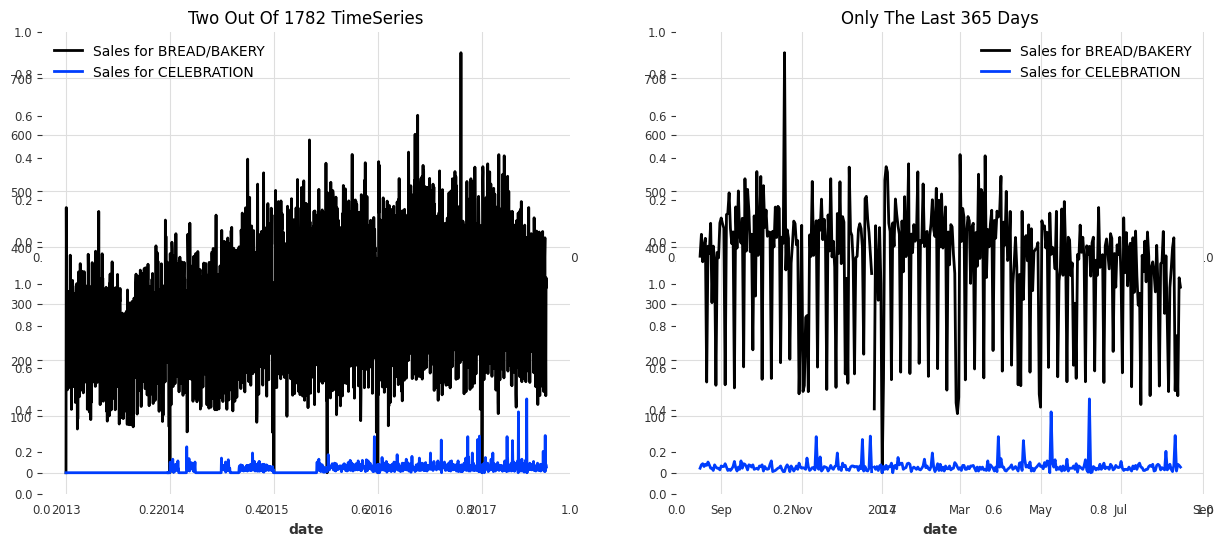

In [14]:
# Разведочный анализ данных (EDA)

# Выбор двух временных рядов для визуализации
bread_series = family_TS_dict['BREAD/BAKERY'][0]  # Первый ряд из категории "Хлеб/Выпечка"
celebration_series = family_TS_dict['CELEBRATION'][11]  # 12-й ряд из категории "Праздничные товары"

# Создание графиков для визуализации временных рядов
plt.subplots(2, 2, figsize=(15, 6))

# График 1: Полные временные ряды
plt.subplot(1, 2, 1)
bread_series.plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1],
                                              bread_series.static_covariates_values()[0,0],
                                              bread_series.static_covariates_values()[0,2]))

celebration_series.plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1],
                                                    celebration_series.static_covariates_values()[0,0],
                                                    celebration_series.static_covariates_values()[0,2]))

plt.title("Two Out Of 1782 TimeSeries")

# График 2: Последние 365 дней временных рядов
plt.subplot(1, 2, 2)
bread_series[-365:].plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1],
                                                     bread_series.static_covariates_values()[0,0],
                                                     bread_series.static_covariates_values()[0,2]))

celebration_series[-365:].plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1],
                                                           celebration_series.static_covariates_values()[0,0],
                                                           celebration_series.static_covariates_values()[0,2]))

plt.title("Only The Last 365 Days")
plt.show()

Text(0.5, 1.0, 'CELEBRATION, store 12 in Latacunga')

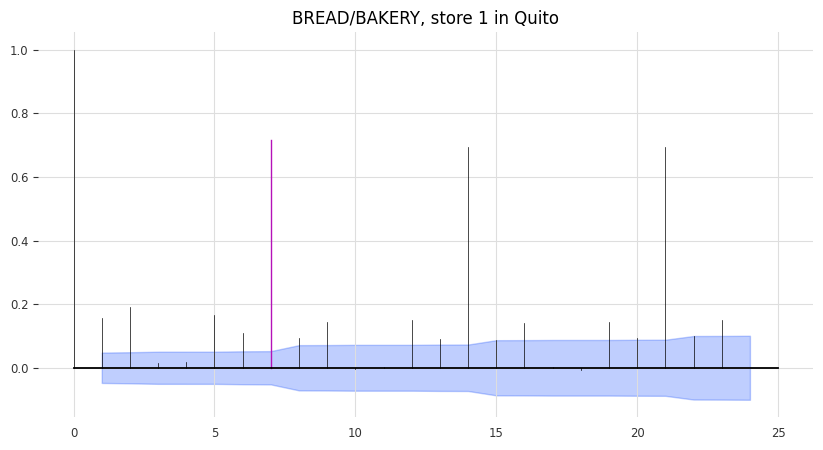

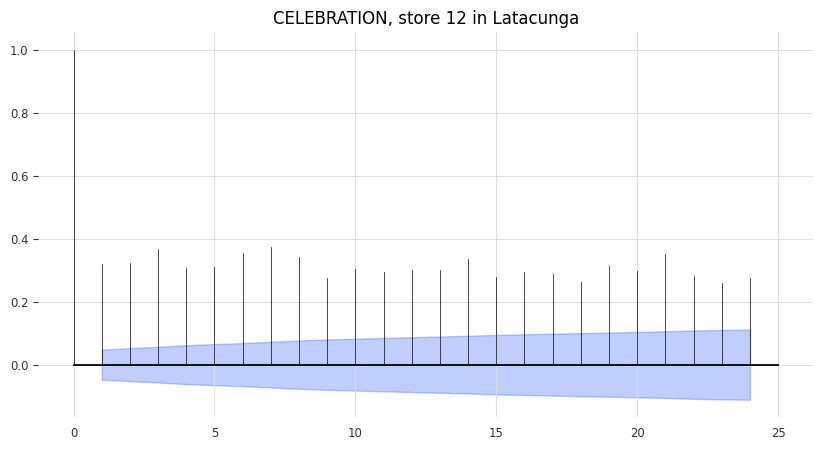

In [15]:
# Анализ сезонности с помощью автокорреляционной функции (ACF)

# ACF для временного ряда продаж хлеба/выпечки
plot_acf(fill_missing_values(bread_series), m=7, alpha=0.05)
plt.title("{}, store {} in {}".format(bread_series.static_covariates_values()[0,1],
                                      bread_series.static_covariates_values()[0,0],
                                      bread_series.static_covariates_values()[0,2]))

# ACF для временного ряда продаж праздничных товаров
plot_acf(fill_missing_values(celebration_series), alpha=0.05)
plt.title("{}, store {} in {}".format(celebration_series.static_covariates_values()[0,1],
                                      celebration_series.static_covariates_values()[0,0],
                                      celebration_series.static_covariates_values()[0,2]))


Как мы видим, ряд BREAD/BAKERY (Хлеб/Выпечка) демонстрирует сильную недельную сезонность, что вполне ожидаемо. Однако ряд CELEBRATION (Праздничные товары) имеет гораздо менее четкий сезонный паттерн.
Я закодировал статические ковариаты и применил масштабирование 0-1 + логарифмическое преобразование ко всем рядам. Статические ковариаты не меняются со временем - примерами в нашем наборе данных являются номер магазина или регион. Масштабирование важно для многих моделей глубокого обучения, а логарифмическое преобразование обучающих данных поможет избежать занижения фактических продаж в наших прогнозах

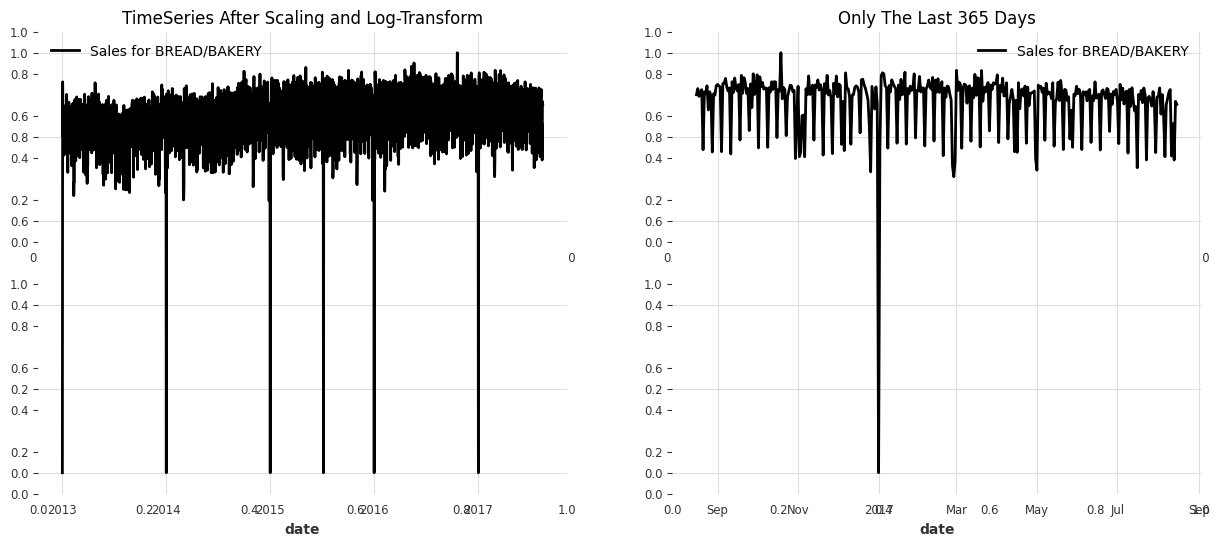

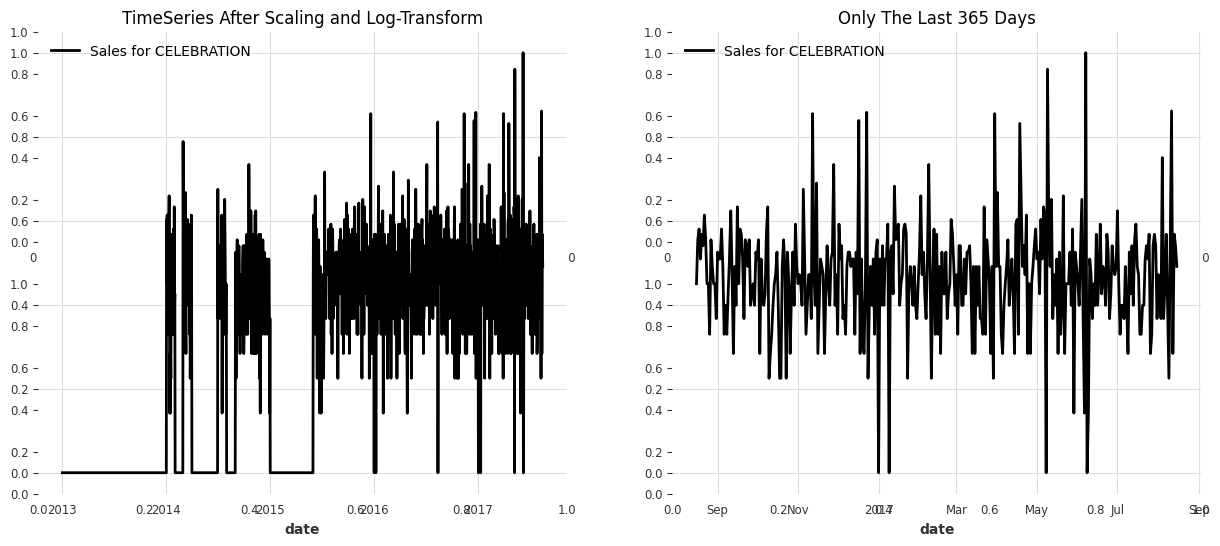

In [16]:
# Преобразование и визуализация временных рядов продаж

# Создание пайплайнов для обработки данных хлеба/выпечки
train_filler_bread = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
static_cov_transformer_bread = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
log_transformer_bread = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")
train_scaler_bread = Scaler(verbose=False, n_jobs=-1, name="Scaling")

# Создание пайплайнов для обработки данных праздничных товаров
train_filler_celebration = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
static_cov_transformer_celebration = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
log_transformer_celebration = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")
train_scaler_celebration = Scaler(verbose=False, n_jobs=-1, name="Scaling")

# Объединение этапов обработки в пайплайны
train_pipeline_bread = Pipeline([train_filler_bread,
                             static_cov_transformer_bread,
                             log_transformer_bread,
                             train_scaler_bread])

train_pipeline_celebration = Pipeline([train_filler_celebration,
                             static_cov_transformer_celebration,
                             log_transformer_celebration,
                             train_scaler_celebration])

# Применение пайплайнов к временным рядам
bread_series_transformed = train_pipeline_bread.fit_transform(bread_series)
celebration_series_transformed = train_pipeline_celebration.fit_transform(celebration_series)

# Визуализация преобразованных данных для хлеба/выпечки
plt.subplots(2, 2, figsize=(15, 6))
plt.subplot(1, 2, 1)
bread_series_transformed.plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1],
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

plt.title("TimeSeries After Scaling and Log-Transform")

plt.subplot(1, 2, 2)
bread_series_transformed[-365:].plot(label='Sales for {}'.format(bread_series.static_covariates_values()[0,1],
                                                bread_series.static_covariates_values()[0,0],
                                                bread_series.static_covariates_values()[0,2]))

plt.title("Only The Last 365 Days")
plt.show()

# Визуализация преобразованных данных для праздничных товаров
plt.subplots(2, 2, figsize=(15, 6))
plt.subplot(1, 2, 1)
celebration_series_transformed.plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1],
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]))

plt.title("TimeSeries After Scaling and Log-Transform")

plt.subplot(1, 2, 2)
celebration_series_transformed[-365:].plot(label='Sales for {}'.format(celebration_series.static_covariates_values()[0,1],
                                                celebration_series.static_covariates_values()[0,0],
                                                celebration_series.static_covariates_values()[0,2]))

plt.title("Only The Last 365 Days")
plt.show()


Продажи и их скользящие средние (7-дневные и 28-дневные).

Данные о промоакциях и их скользящие средние.

Данные о транзакциях и их скользящие средние.

Цены на нефть и их скользящие средние.

Временные ковариаты (например, день недели, месяц, год).

Text(0.5, 1.0, 'Time-Related Covariates')

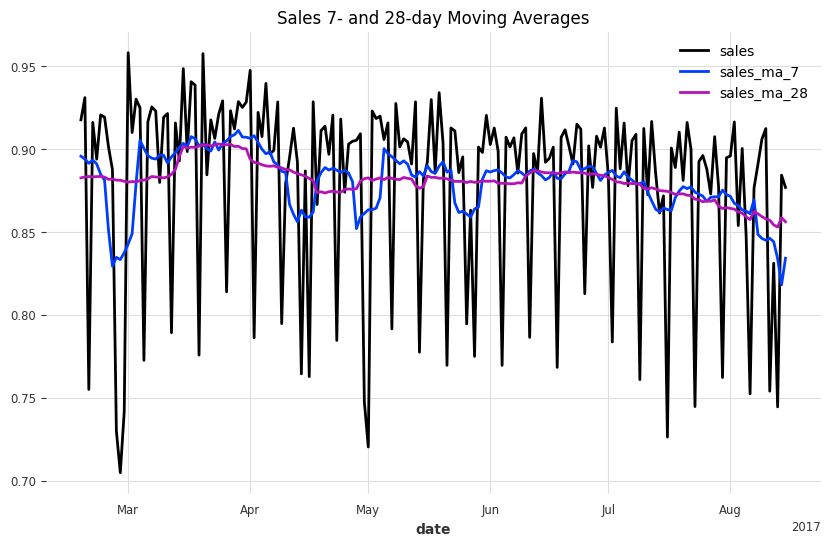

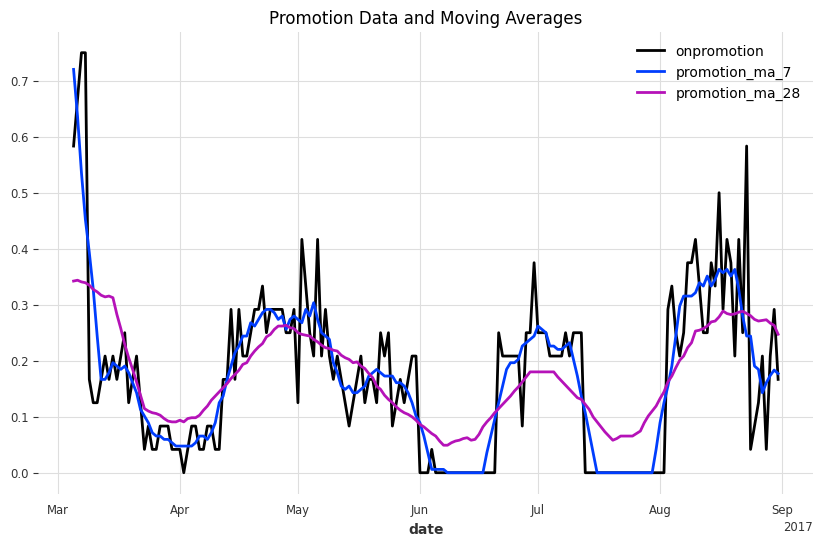

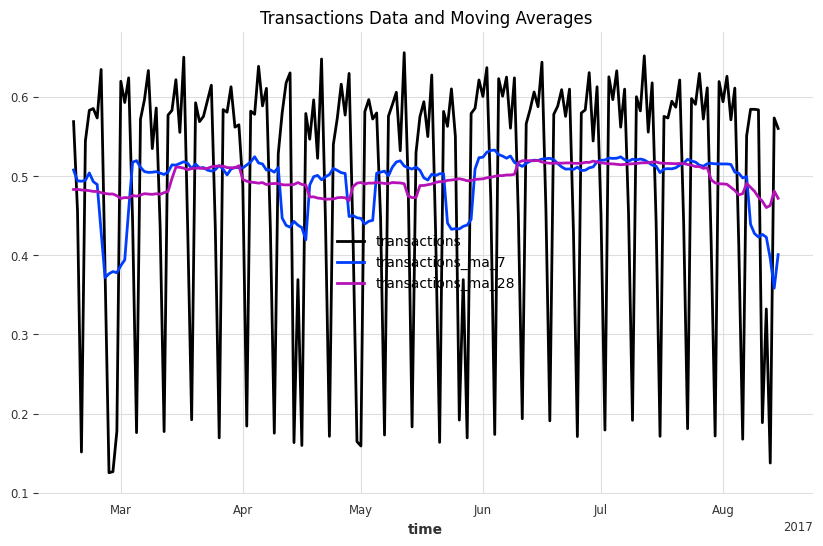

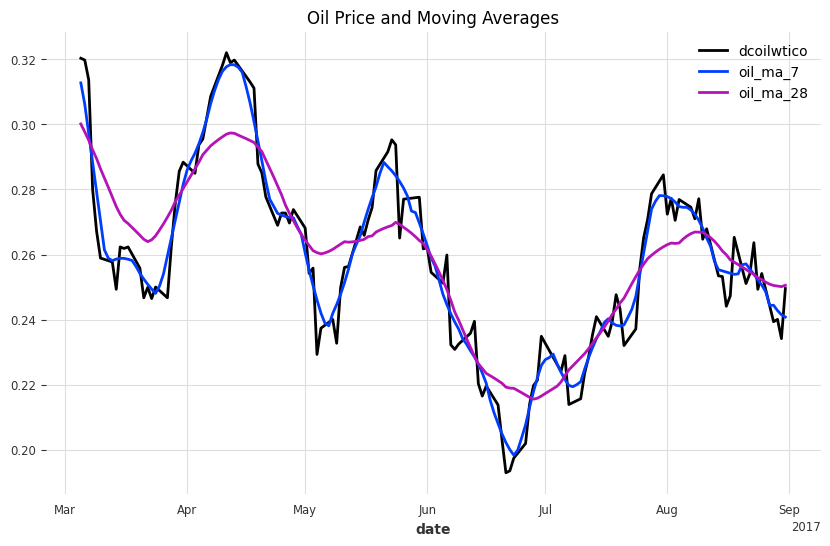

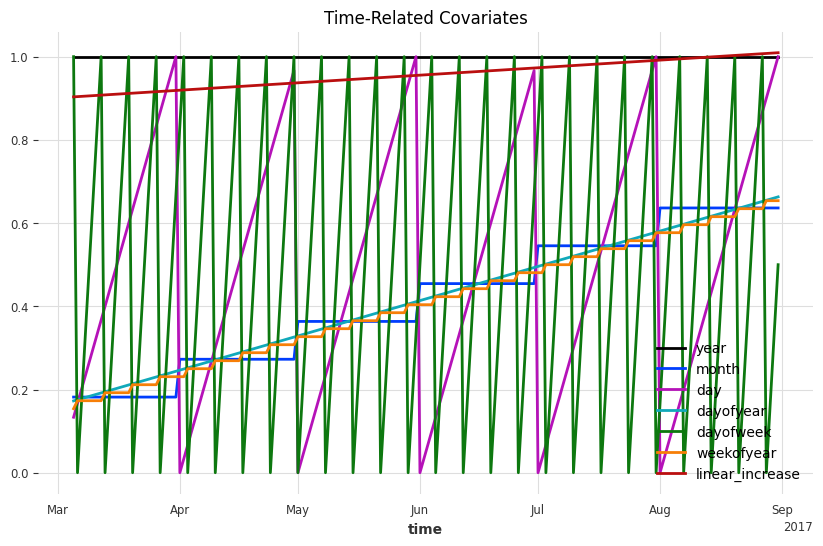

In [17]:
# Визуализация ковариат для последних 180 дней продаж хлеба/выпечки в магазине 1

# График продаж и скользящих средних
plt.figure(figsize=(10, 6))
family_TS_transformed_dict['BREAD/BAKERY'][0][-180:].plot()  # Продажи хлеба/выпечки
sales_moving_averages_dict['BREAD/BAKERY'][0][-180:].plot()  # Скользящие средние продаж
plt.title("Sales 7- and 28-day Moving Averages")

# График данных о промоакциях
plt.figure(figsize=(10, 6))
promotion_transformed_dict['BREAD/BAKERY'][0][-180:].plot()
plt.title("Promotion Data and Moving Averages")

# График данных о транзакциях
plt.figure(figsize=(10, 6))
transactions_covs[0][-180:].plot()
plt.title("Transactions Data and Moving Averages")

# График цен на нефть
plt.figure(figsize=(10, 6))
oil_transformed[-180:].plot()  # Трансформированные цены на нефть
oil_moving_averages[-180:].plot()  # Скользящие средние цен на нефть
plt.title("Oil Price and Moving Averages")

# График временных ковариат
plt.figure(figsize=(10, 6))
time_cov_transformed[-180:].plot()
plt.title("Time-Related Covariates")


Text(0.5, 1.0, 'Holidays and Events')

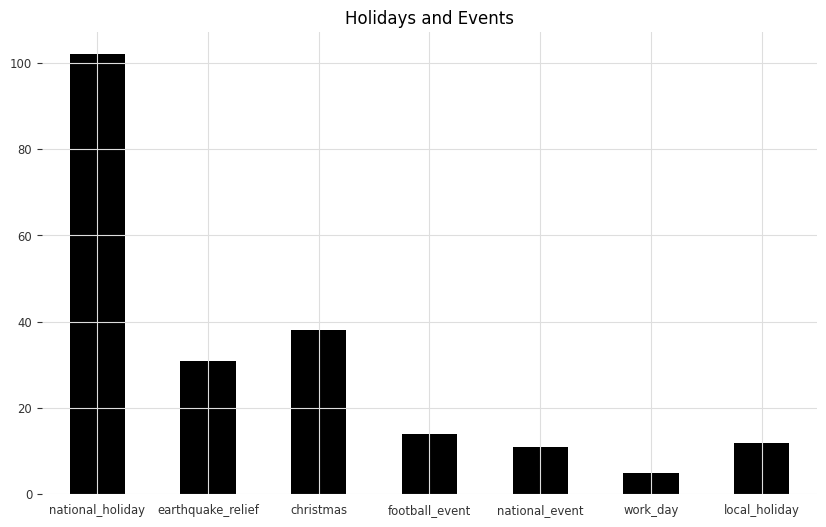

In [18]:
# Визуализация праздников и событий

plt.figure(figsize=(10, 6))

# Выбор данных о праздниках для первого магазина (индекс 0)
# Суммирование количества каждого типа праздника/события
# Исключение столбца 'date' из подсчета
holiday_counts = list_of_holidays_per_store[0].loc[:, list_of_holidays_per_store[0].columns != "date"].sum()

# Создание столбчатой диаграммы
holiday_counts.plot.bar(rot=0)

plt.title("Holidays and Events")


Этот график позволяет визуально оценить распределение различных типов праздников и событий. Это может быть полезно для понимания, какие типы праздников наиболее часто встречаются и, следовательно, могут оказывать наибольшее влияние на продажи.


# Baseline

Базовая прогнозируемая производительность представляет собой нижнюю границу ожидаемой производительности моделей машинного обучения. Я использовал три простые в реализации модели:

Наивная сезонная модель (повторяющаяся за последние 7 дней)

Экспоненциальное сглаживание

Facebook Prophet

Экспоненциальное сглаживание дало наилучшие результаты. По соображениям вычислительных реусурсов я прокомментировал результаты обучения/ оценки двух других моделей позже.

## Несколько тестов

In [19]:
from darts.models import NaiveSeasonal, ExponentialSmoothing, Prophet
from darts.timeseries import concatenate
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [20]:
Naive_Seasonal_Model = NaiveSeasonal(K=7)
Exponential_Smoothing_Model = ExponentialSmoothing()
Prophet_Model = Prophet()

Функция для оценки и визуализации бэктеста:

In [21]:
def eval_backtest(backtest_series, actual_series, horizon, transformer, model):
    actualdata = transformer.inverse_transform(actual_series, partial=True)
    forecasts = transformer.inverse_transform(backtest_series, partial=True)
    plt.figure(figsize=(10, 6))
    actualdata[-365:].plot(label="Actual Data")
    forecasts.plot(label=model)
    plt.legend()
    plt.suptitle("{} in store {} ({})".format(static_cov_transformer_bread.inverse_transform(actual_series).static_covariates_values()[0,1],
                                                static_cov_transformer_bread.inverse_transform(actual_series).static_covariates_values()[0,0],
                                                static_cov_transformer_bread.inverse_transform(actual_series).static_covariates_values()[0,2]))
    plt.title("Backtest with {}-months horizon, RMSLE = {:.2f}".format(horizon,
            rmsle(actual_series=actualdata, pred_series=forecasts)))

Для каждой модели проводится бэктест с использованием метода historical_forecasts. Бэктест начинается с 1 ноября 2016 года, имеет горизонт прогнозирования 16 дней и шаг 16 дней.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


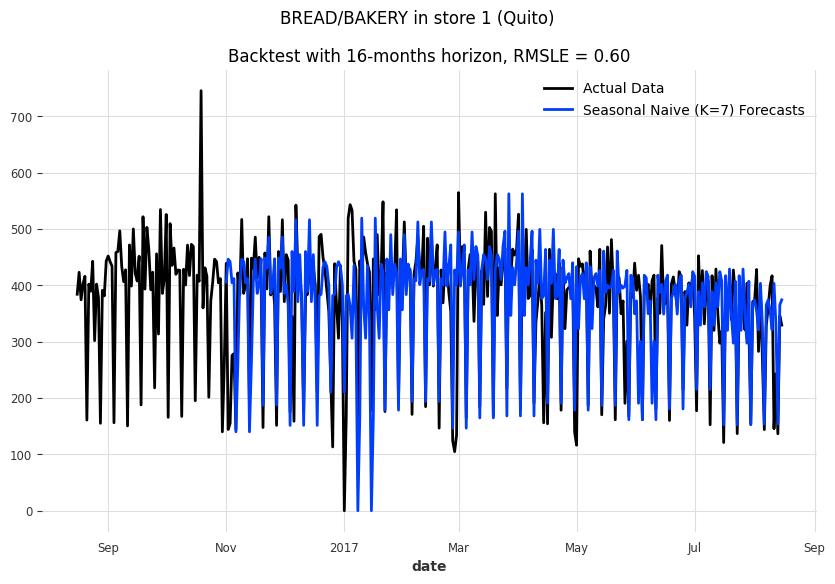

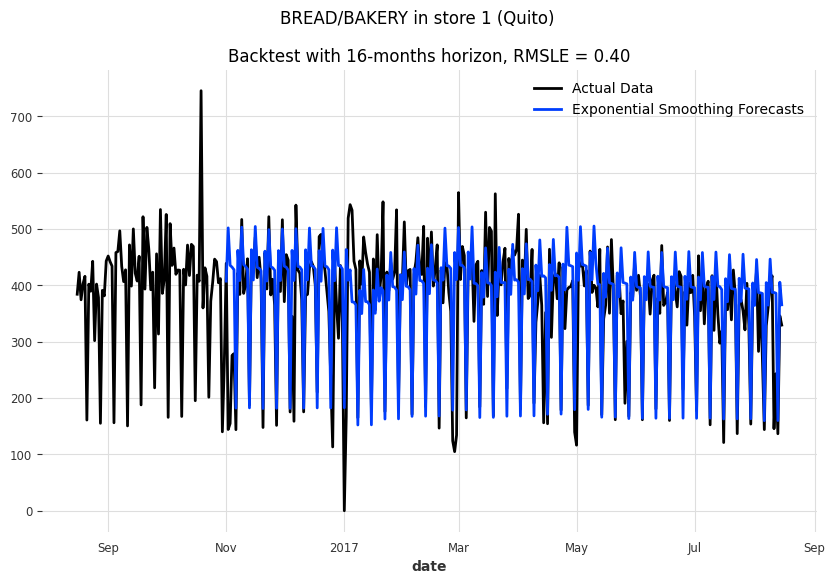

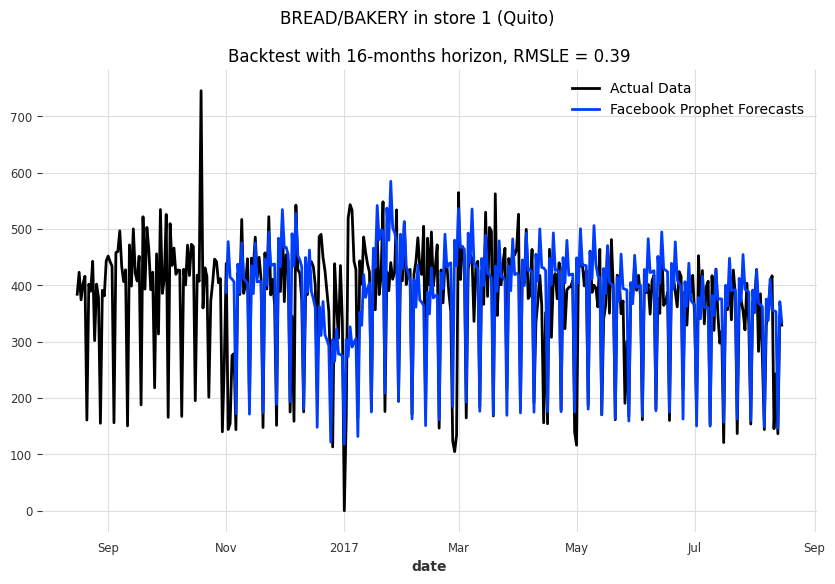

In [22]:
backtest_series_SN = Naive_Seasonal_Model.historical_forecasts(
    bread_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_ES = Exponential_Smoothing_Model.historical_forecasts(
    bread_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_Prophet = Prophet_Model.historical_forecasts(
    bread_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)


eval_backtest(
    backtest_series=concatenate(backtest_series_SN),
    actual_series=bread_series_transformed,
    horizon=16,
    transformer=train_pipeline_bread,
    model="Seasonal Naive (K=7) Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_ES),
    actual_series=bread_series_transformed,
    horizon=16,
    transformer=train_pipeline_bread,
    model="Exponential Smoothing Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_Prophet),
    actual_series=bread_series_transformed,
    horizon=16,
    transformer=train_pipeline_bread,
    model="Facebook Prophet Forecasts"
)

За исключением нулевых продаж в период Рождества/Нового года 2017, ряд следует очень последовательному паттерну - люди едят хлеб каждую неделю. Все три модели способны довольно хорошо предсказать этот паттерн. Однако наивная сезонная модель сильно ошибается после наблюдаемого единичного резкого спада.

Теперь давайте посмотрим на более сложный ряд - в качестве примера я выбрал семейство продуктов CELEBRATION в магазине 19. Хотя этот ряд также имеет сезонные паттерны, он демонстрирует гораздо больше резких скачков. Как теперь справятся наши базовые модели?

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


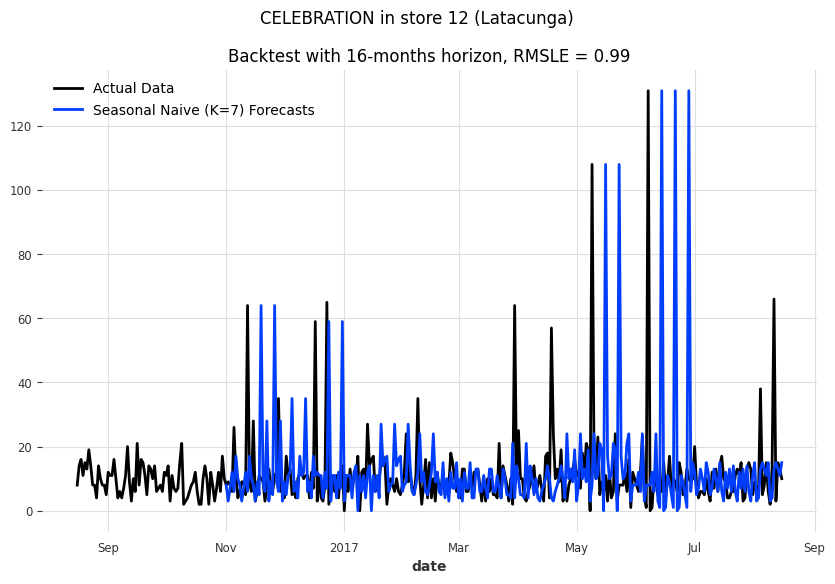

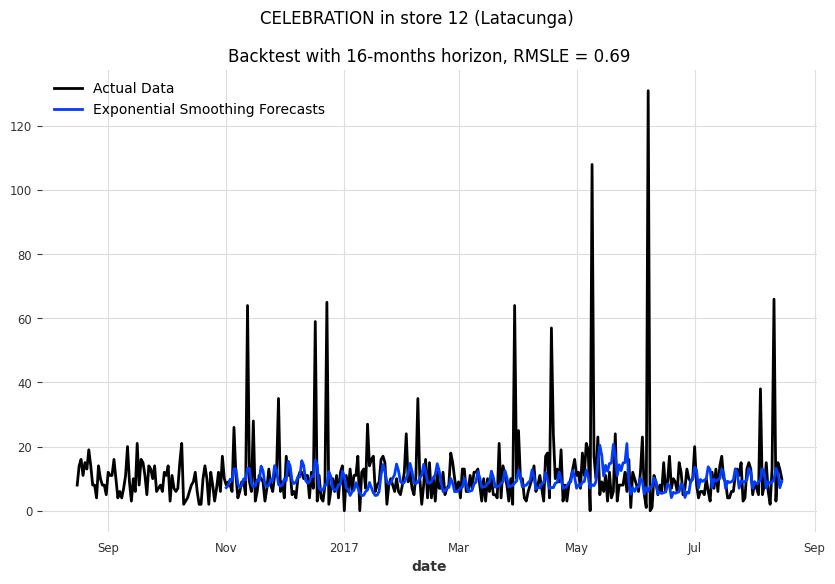

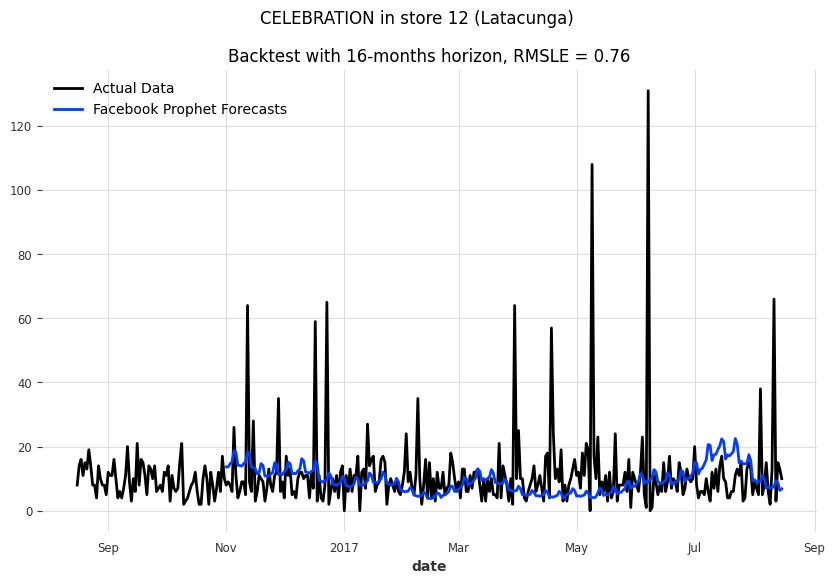

In [23]:
def eval_backtest(backtest_series, actual_series, horizon, transformer, model):
    actualdata = transformer.inverse_transform(actual_series, partial=True)
    forecasts = transformer.inverse_transform(backtest_series, partial=True)
    plt.figure(figsize=(10, 6))
    actualdata[-365:].plot(label="Actual Data")
    forecasts.plot(label=model)
    plt.legend()
    plt.suptitle("{} in store {} ({})".format(static_cov_transformer_celebration.inverse_transform(actual_series).static_covariates_values()[0,1],
                                                static_cov_transformer_celebration.inverse_transform(actual_series).static_covariates_values()[0,0],
                                                static_cov_transformer_celebration.inverse_transform(actual_series).static_covariates_values()[0,2]))
    plt.title("Backtest with {}-months horizon, RMSLE = {:.2f}".format(horizon,
            rmsle(actual_series=actualdata, pred_series=forecasts)))

backtest_series_SN_2 = Naive_Seasonal_Model.historical_forecasts(
    celebration_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_ES_2 = Exponential_Smoothing_Model.historical_forecasts(
    celebration_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)

backtest_series_Prophet_2 = Prophet_Model.historical_forecasts(
    celebration_series_transformed,
    start=pd.Timestamp('20161101'),
    forecast_horizon=16,
    stride=16,
    last_points_only=False,
    retrain=True,
    verbose=False,
)


eval_backtest(
    backtest_series=concatenate(backtest_series_SN_2),
    actual_series=celebration_series_transformed,
    horizon=16,
    transformer=train_pipeline_celebration,
    model="Seasonal Naive (K=7) Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_ES_2),
    actual_series=celebration_series_transformed,
    horizon=16,
    transformer=train_pipeline_celebration,
    model="Exponential Smoothing Forecasts"
)

eval_backtest(
    backtest_series=concatenate(backtest_series_Prophet_2),
    actual_series=celebration_series_transformed,
    horizon=16,
    transformer=train_pipeline_celebration,
    model="Facebook Prophet Forecasts"
)

Эти прогнозы не идеальны - предсказание продаж оказывается не таким простым делом. Скачки в продажах товаров категории "CELEBRATION" вероятно вызваны особыми событиями.

В то время как наивная сезонная модель генерирует много ложно предсказанных скачков (и пропускает большинство реальных), модели экспоненциального сглаживания и Prophet улавливают базовые сезонные паттерны и тренды, но пропускают все скачки. Следуя этим прогнозам, наши супермаркеты не будут иметь достаточно праздничных товаров, когда на них наибольший спрос, упуская значительную прибыль.

Из этого небольшого эксперимента мы уже можем видеть, что хорошие модели должны как улавливать общую сезонность и тренды в продажах продуктов, так и понимать предсказуемые скачки и другие особые паттерны. Поскольку у нас есть данные о праздниках, например, это должно быть возможно в некоторой степен

## Реализация train/test выборок


Text(0.5, 1.0, 'BREAD/BAKERY in store 1 (Quito)')

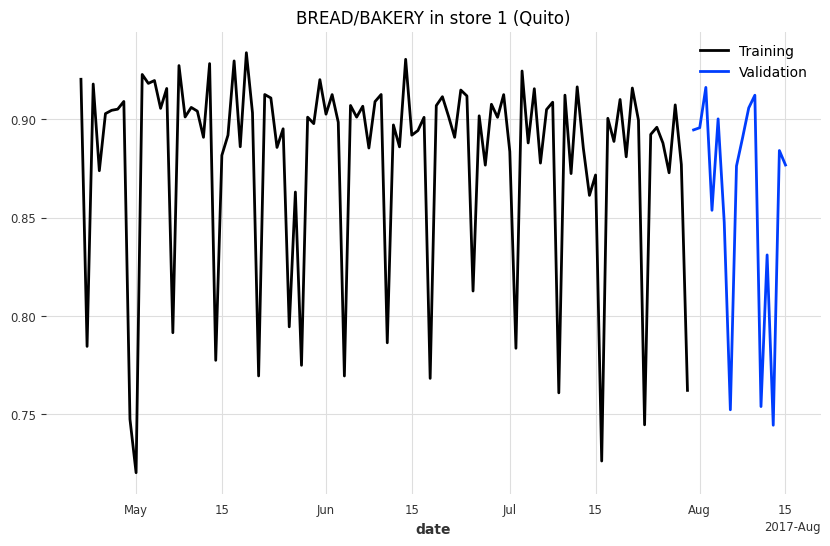

In [24]:
# Создание обучающего и валидационного набора данных для целевого ряда
training_series_bread = bread_series_transformed[:-16]
val_series_bread = bread_series_transformed[-16:]

# Визуализация обучающего и валидационного набора
plt.figure(figsize=(10, 6))
training_series_bread[-100:].plot(label='Training')
val_series_bread.plot(label='Validation')
plt.legend()
plt.title("{} in store {} ({})".format(bread_series.static_covariates_values()[0,1],
                                       bread_series.static_covariates_values()[0,0],
                                       bread_series.static_covariates_values()[0,2]))


Для наших базовых методов мы сейчас обучаем 1782 модели, по одной для каждой (семейство хранилищ x) Временные ряды. Прогнозы, созданные с помощью этих моделей, затем будут преобразованы обратно в исходный масштаб. Кроме того, мы прогнозируем нулевые прогнозы для всех серий, которые не продавались в течение последних двух недель (несколько произвольный выбор).

Эта функция создает и обучает модели экспоненциального сглаживания для каждого временного ряда в списке training_list. Она возвращает список обученных моделей.

In [25]:
def ESModelBuilder(training_list):
    listofESmodels = []
    for i in range(0,len(training_list)):
        ES_model = ExponentialSmoothing()
        ES_model.fit(training_list[i])
        listofESmodels.append(ES_model)
    return listofESmodels


Эта функция использует список обученных моделей для создания прогнозов на 16 шагов вперед для каждой модели. Возвращает список прогнозов.

In [26]:
def ESForecaster(model_list):
    listofESpreds = []
    for i in range(0,len(model_list)):
        pred_ES = model_list[i].predict(n=16)
        listofESpreds.append(pred_ES)
    return listofESpreds

Основной цикл обучения и прогнозирования:

In [27]:
seafood_data = family_TS_transformed_dict['SEAFOOD']
seafood_static_covariates_shapes = [ts.static_covariates.shape if ts.static_covariates is not None else None for ts in seafood_data]
seafood_missing_values = [ts.pd_dataframe().isnull().sum().sum() for ts in seafood_data]

print("Shapes of static covariates:", seafood_static_covariates_shapes)
print("Number of missing values:", seafood_missing_values)


Shapes of static covariates: [(1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115), (1, 115)]
Number of missing values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
def process_seafood(seafood_data):
    processed_data = []
    for ts in seafood_data:
        values = ts.values()
        normalized_values = (values - values.min()) / (values.max() - values.min())
        processed_ts = TimeSeries.from_times_and_values(ts.time_index, normalized_values)
        processed_data.append(processed_ts)
    return processed_data

seafood_processed = process_seafood(seafood_data)

In [31]:
ES_Models_Family_Dict = {}
ES_Forecasts_Family_Dict = {}

In [32]:
ES_Models_Seafood = ESModelBuilder(seafood_processed)
forecasts_ES_Seafood = ESForecaster(ES_Models_Seafood)

# Не применяем обратное преобразование
ES_Forecasts_Family_Dict['SEAFOOD'] = forecasts_ES_Seafood

In [33]:
for family in tqdm(family_list):
    if family != 'SEAFOOD':
        try:
            sales_family = family_TS_transformed_dict[family]
            training_data = [ts[:-16] for ts in sales_family]

            ES_Models_Family_Dict[family] = ESModelBuilder(training_data)
            forecasts_ES = ESForecaster(ES_Models_Family_Dict[family])

            ES_Forecasts_Family_Dict[family] = family_pipeline_dict[family].inverse_transform(forecasts_ES, partial=True)

            # Zero Forecasting
            for i in range(len(ES_Forecasts_Family_Dict[family])):
                if (training_data[i].univariate_values()[-14:] == 0).all():
                    ES_Forecasts_Family_Dict[family][i] = ES_Forecasts_Family_Dict[family][i].map(lambda x: x * 0)

        except Exception as e:
            print(f"Error processing family {family}: {e}")


100%|██████████| 33/33 [11:20<00:00, 20.61s/it]


Проходит по всем семействам продуктов.

Для каждого семейства создает и обучает модели на данных до последних 16 точек.

Создает прогнозы на 16 точек вперед.

Применяет обратное преобразование к прогнозам.

Если последние 14 значений обучающих данных были нулевыми, устанавливает
прогноз в ноль.

Измеряет время выполнения всего процесса.

In [41]:
# Переформатирование прогнозов из словарей в один список
forecast_list_ES = []
for family in family_list:
    forecast_list_ES.append(ES_Forecasts_Family_Dict[family])

# Создание списка фактических данных о продажах
sales_data = []
for family in family_list:
    sales_data.append(family_TS_dict[family])

# Функция для "выравнивания" вложенных списков
def flatten(l):
    return [item for sublist in l for item in sublist]

# Применение функции flatten к спискам фактических данных и прогнозов
actual_list = flatten(sales_data)
pred_list_ES = flatten(forecast_list_ES)

# Вычисление среднего RMSLE
ES_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_ES,
                 n_jobs = -1,
                 inter_reduction=np.mean)

# Вывод результатов
print("\n")
print("The mean RMSLE for the Local Exponential Smoothing Models over 1782 series is {:.5f}.".format(ES_rmsle))
print('Training & Inference duration:', elapsed_time_exp, 'seconds')
print("\n")

Преобразует прогнозы и фактические данные о продажах из словарей в списки, где каждый элемент соответствует одному семейству продуктов.
Использует функцию flatten для преобразования вложенных списков в одномерные списки. Это необходимо, так как каждое семейство продуктов может содержать несколько временных рядов.
Вычисляет среднее значение RMSLE (Root Mean Squared Logarithmic Error) для всех временных рядов, используя функцию rmsle из библиотеки Darts. Параметр n_jobs=-1 указывает на использование всех доступных ядер процессора для ускорения вычислений.
Выводит среднее значение RMSLE и время, затраченное на обучение модели и создание прогнозов.

In [42]:
# Mean RMSLE for Families

family_forecast_rmsle_ES = {}

for family in family_list:

  ES_rmsle_family = rmsle(actual_series = family_TS_dict[family],
                 pred_series = ES_Forecasts_Family_Dict[family],
                 n_jobs = -1,
                 inter_reduction=np.mean)

  family_forecast_rmsle_ES[family] = ES_rmsle_family


family_forecast_rmsle_ES = dict(sorted(family_forecast_rmsle_ES.items(), key=lambda item: item[1]))

print("\n")
print("Mean RMSLE for the 33 different product families, from worst to best:")
print("\n")

# Iterate over key/value pairs in dict and print them
for key, value in family_forecast_rmsle_ES.items():
    print(key, ' : ', value)


# N-HiTS

Для небольших наборов данных с малым количеством измерений сложные модели (особенно нейронные сети) не дают значительных преимуществ. Часто более простые статистические модели превосходят их.

Нейронные сети - сложные нелинейные модели, не навязывающие структуру данным. Статистические методы (ARIMA, экспоненциальное сглаживание, Prophet) имеют фиксированную структуру и меньшую гибкость. Для одиночных временных рядов с небольшим количеством точек такая гибкость не нужна.


Данные о продажах магазинов состоят из 1782 длинных временных рядов с релевантными ковариатами.

Использовать глобальные модели (нейронные сети и бустинг) для извлечения максимума информации из большого набора данных. В отличие от локальных моделей, глобальные обучаются на нескольких временных рядах одновременно.

Три модели глубокого обучения: LSTM, N-HiTS и TFT, отмечая их различные подходы к использованию ковариат.

In [44]:
# Data Preparation for N-HiTS

def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])

future_covariates_full = flatten(future_covariates_full)

# Shift future covariates back so they can be used as past covariates

only_past_covariates = []

for family in family_list:
  only_past_covariates.append(only_past_covariates_dict[family])

only_past_covariates = flatten(only_past_covariates)

NHiTS_covariates = []

for i in range(0,len(future_covariates_full)):
  shifted = future_covariates_full[i].shift(n=-16)
  cut = shifted.slice_intersect(only_past_covariates[i])
  stacked = cut.stack(only_past_covariates[i])
  NHiTS_covariates.append(stacked)

# Split in train/val/test for Tuning and Validation

val_len = 16

train = [s[: -(2 * val_len)] for s in training_transformed]
val = [s[-(2 * val_len) : -val_len] for s in training_transformed]
test = [s[-val_len:] for s in training_transformed]

In [45]:
""" We write a function to build and fit a N-HiTS Model, which we will re-use later.
"""

def build_fit_nhits_model(
    input_chunk_length,
    num_stacks,
    num_blocks,
    num_layers,
    layer_exp,
    dropout,
    lr,
    likelihood=None,
    callbacks=None,
    #max_samples=None
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_N_EPOCHS = 50
    MAX_SAMPLES_PER_TS = 180

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.0001, patience=2, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": 1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }

        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the N-HiTS model
    model = NHiTSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=16,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2 ** layer_exp,
        dropout=dropout,
        n_epochs=MAX_N_EPOCHS,
        batch_size=128,
        add_encoders=None,
        likelihood=None,
        loss_fn=torch.nn.MSELoss(),
        random_state=42,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="nhits_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + input_chunk_length) : -val_len] for s in training_transformed]


    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=NHiTS_covariates,
        val_past_covariates=NHiTS_covariates,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = NHiTSModel.load_from_checkpoint("nhits_model")

    return model

In [49]:
# Hyperparameter Tuning with Optuna

def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 21 and 365 days
    input_chunk_length = trial.suggest_int("input_chunk_length", 63, 270)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 3)
    num_blocks = trial.suggest_int("num_blocks", 1, 3)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    layer_exp = trial.suggest_int("layer_exp", 7, 10)
    #layer_widths = 2 ** layer_exp
    dropout = trial.suggest_float("dropout", 0.01, 0.2, step=0.01)
    lr = trial.suggest_float("lr", 5e-5, 0.1, log=True)

    # build and train the N-HiTS model with these hyper-parameters:
    model = build_fit_nhits_model(
                        input_chunk_length=input_chunk_length,
                        num_stacks=num_stacks,
                          num_blocks=num_blocks,
                        num_layers=num_layers,
                        layer_exp=layer_exp,
                          dropout=dropout,
                              lr=lr,
                          likelihood=None,
                          callbacks=callback,
                          #max_samples=365
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=train, past_covariates=NHiTS_covariates, n=val_len)
    rmsles = rmsle(val, preds, n_jobs=-1, verbose=True)
    rmsle_val = np.mean(rmsles)

    return rmsle_val if rmsle_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


torch.cuda.empty_cache()

study_nhits = optuna.create_study(direction="minimize")

study_nhits.optimize(objective, n_trials=5, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study_nhits.best_value}, Best params: {study_nhits.best_trial.params}")

In [51]:
nhits_params = study_nhits.best_trial.params

# get the start time
st = time.time()

NHiTS_Model = build_fit_nhits_model(**nhits_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in training_transformed]
preds = NHiTS_Model.predict(series=training_data, past_covariates=NHiTS_covariates, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_nhits = et - st

# Mean RMSLE

NHiTS_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)

In [52]:
print("\n")
print("The mean RMSLE for the Global N-HiTS Model over 1782 series is {:.5f}.".format(NHiTS_rmsle))
print('Training & Inference duration:', elapsed_time_nhits, 'seconds')
print("\n")

# LSTM

LSTM поддерживает только ковариаты, известные в будущем. Чтобы также использовать данные из наших ковариат, известных только в прошлом (данные о продажах и транзакциях), я сдвигаю их на 16 дней вперед в будущее. Хотя этот подход может быть не оптимальным, я обнаружил, что он работает лучше, чем полное исключение этих ковариат.
Небольшая тонкая настройка дала мне следующие гиперпараметры для LSTM:
Input_chunk_length: 131
hidden_dim: 39
n_rnn_layers: 3
learning rate: 0.0019971227090605087
Давайте обучим эту модель на всех наших данных и сделаем прогноз на 16-дневный тестовый набор!

In [ ]:
# Data Preparation for LSTM

def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])

future_covariates_full = flatten(future_covariates_full)

# Shift past covariates forward so they can be used as future covariates


only_past_covariates = []

for family in family_list:
  only_past_covariates.append(only_past_covariates_dict[family])

only_past_covariates = flatten(only_past_covariates)


LSTM_covariates = []

for i in range(0,len(only_past_covariates)):
  shifted = only_past_covariates[i].shift(n=16)
  cut = future_covariates_full[i].slice_intersect(shifted)
  stacked = cut.stack(shifted)
  LSTM_covariates.append(stacked)

# Slice-Intersect target and covariates after shifting

LSTM_target = []

for i in range(0, len(training_transformed)):
  sliced = training_transformed[i].slice_intersect(LSTM_covariates[i])
  LSTM_target.append(sliced)

# Split in train/val/test for Tuning and Validation

val_len = 16

LSTM_train = [s[: -(2 * val_len)] for s in LSTM_target]
LSTM_val = [s[-(2 * val_len) : -val_len] for s in LSTM_target]
LSTM_test = [s[-val_len:] for s in LSTM_target]

In [ ]:
""" We write a function to build and fit a TCN Model, which we will re-use later.
"""

def build_fit_lstm_model(
    input_chunk_length,
    hidden_dim,
    n_rnn_layers,
  #  dropout,
  #  training_length,
  #  batch_size,
  #  n_epochs,
    lr,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_N_EPOCHS = 100
    MAX_SAMPLES_PER_TS = 60

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.0001, patience=2, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": 1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the LSTM model
    model = RNNModel(
        model="LSTM",
        input_chunk_length=input_chunk_length,
        hidden_dim=hidden_dim,
        n_rnn_layers=n_rnn_layers,
        dropout=0,
        training_length=input_chunk_length + val_len -1,
        n_epochs=MAX_N_EPOCHS,
        batch_size=128,
        add_encoders=None,
        likelihood=None,
        loss_fn=torch.nn.MSELoss(),
        random_state=42,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="lstm_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + input_chunk_length) : -val_len] for s in LSTM_target]


    # train the model
    model.fit(
        series=LSTM_train,
        val_series=model_val_set,
        future_covariates=LSTM_covariates,
        val_future_covariates=LSTM_covariates,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = RNNModel.load_from_checkpoint("lstm_model")

    return model

In [ ]:
lstm_params = {'input_chunk_length': 131,
               'hidden_dim': 39,
               'n_rnn_layers': 3,
               'lr': 0.0019971227090605087}

torch.cuda.empty_cache()

# get the start time
st = time.time()

LSTM_Model = build_fit_lstm_model(**lstm_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in LSTM_target]
preds = LSTM_Model.predict(series=training_data, future_covariates=LSTM_covariates, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (LSTM_target[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)


# get the end time
et = time.time()

# get the execution time
elapsed_time_lstm = et - st

# Mean RMSLE

LSTM_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)

In [ ]:
print("\n")
print("The mean RMSLE for the Global LSTM Model over 1782 series is {:.5f}.".format(LSTM_rmsle))
print('Training & Inference duration:', elapsed_time_lstm, 'seconds')
print("\n")

# TFT

TFT (Temporal Fusion Transformer)
Модель TFT изначально поддерживает все типы ковариат, включая статические. Однако она требует очень больших вычислительных ресурсов.
Я буду использовать следующие гиперпараметры:
input_chunk_length (длина входного чанка): 230
output_chunk_length (длина выходного чанка): 16
hidden_size (размер скрытого слоя): 16
lstm_layers (количество слоев LSTM): 3
num_attention_heads (количество голов внимания): 4
full_attention (полное внимание): True
hidden_continuous_size (размер скрытого непрерывного слоя): 16
dropout (отсев): 0.060000000000000005
lr (скорость обучения): 0.009912733600616069


In [ ]:
# Data Preparation for TFT

def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])

future_covariates_full = flatten(future_covariates_full)


only_past_covariates_full = []

for family in family_list:
  only_past_covariates_full.append(only_past_covariates_dict[family])

only_past_covariates_full = flatten(only_past_covariates_full)

# Split in train/val/test for Tuning and Validation

val_len = 16

train = [s[: -(2 * val_len)] for s in training_transformed]
val = [s[-(2 * val_len) : -val_len] for s in training_transformed]
test = [s[-val_len:] for s in training_transformed]

In [ ]:
""" We write a function to build and fit a TCN Model, which we will re-use later.
"""


def build_fit_tft_model(
    input_chunk_length,
    output_chunk_length,
    hidden_size,
    lstm_layers,
    num_attention_heads,
    full_attention,
    #feed_forward,
    hidden_continuous_size,
    dropout,
    #batch_size,
    #add_relative_index,
    lr,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_N_EPOCHS = 100
    MAX_SAMPLES_PER_TS = 7

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.0001, patience=2, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": 1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the TFT model
    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention =full_attention,
        #feed_forward = feed_forward,
        hidden_continuous_size = hidden_continuous_size,
        dropout=dropout,
        batch_size=128,
        n_epochs=MAX_N_EPOCHS,
        #add_relative_index=add_relative_index,
        add_encoders=None,
        likelihood=None,
        loss_fn=torch.nn.MSELoss(),
        random_state=42,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tft_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + input_chunk_length) : -val_len] for s in training_transformed]


    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_full,
        val_past_covariates=only_past_covariates_full,
        future_covariates=future_covariates_full,
        val_future_covariates=future_covariates_full,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = TFTModel.load_from_checkpoint("tft_model")

    return model

In [ ]:
tft_params = {'input_chunk_length': 230,
              'output_chunk_length': 16,
              'hidden_size': 16,
              'lstm_layers': 3,
              'num_attention_heads': 4,
              'full_attention': True,
              'hidden_continuous_size': 16,
              'dropout': 0.060000000000000005,
              'lr': 0.009912733600616069}

torch.cuda.empty_cache()

# get the start time
st = time.time()

TFT_Model = build_fit_tft_model(**tft_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in training_transformed]
preds = TFT_Model.predict(series=training_data, past_covariates=only_past_covariates_full, future_covariates=future_covariates_full, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_tft = et - st

# Mean RMSLE

TFT_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)

In [ ]:
print("\n")
print("The mean RMSLE for the Global TFT Model over 1782 series is {:.5f}.".format(TFT_rmsle))
print('Training & Inference duration:', elapsed_time_tft, 'seconds')
print("\n")

# Boosted Trees¶


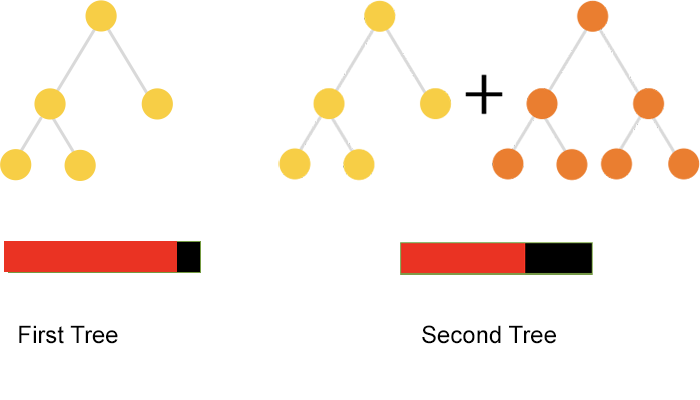

Несмотря на то, что я сосредоточился на моделях глубокого обучения, я обнаружил, что модели на основе бустинга деревьев показывают лучшие результаты для этой задачи прогнозирования. Darts предлагает реализации LightGBM и CatBoost.
Из-за проблем с нехваткой памяти в ядре Kaggle я пока закомментировал обучение бустинговых деревьев. Однако, основываясь на предыдущих блокнотах и обучении на Colab, я могу сказать, что эти модели до сих пор давали лучшие результаты.

In [53]:
"""
def flatten(l):
  return [item for sublist in l for item in sublist]

future_covariates_full = []

for family in family_list:
  future_covariates_full.append(future_covariates_dict[family])

future_covariates_full = flatten(future_covariates_full)


only_past_covariates_full = []

for family in family_list:
  only_past_covariates_full.append(only_past_covariates_dict[family])

only_past_covariates_full = flatten(only_past_covariates_full)


only_past_covariates_shifted = []

for ts in only_past_covariates_full:
  shifted = ts.shift(n=16)
  only_past_covariates_shifted.append(shifted)

# Split in train/val/test for Tuning and Validation

val_len = 16

train = [s[: -(2 * val_len)] for s in training_transformed]
val = [s[-(2 * val_len) : -val_len] for s in training_transformed]
test = [s[-val_len:] for s in training_transformed]
"""

'\ndef flatten(l):\n  return [item for sublist in l for item in sublist]\n\nfuture_covariates_full = []\n\nfor family in family_list:\n  future_covariates_full.append(future_covariates_dict[family])\n    \nfuture_covariates_full = flatten(future_covariates_full)\n\n\nonly_past_covariates_full = []\n\nfor family in family_list:\n  only_past_covariates_full.append(only_past_covariates_dict[family])\n    \nonly_past_covariates_full = flatten(only_past_covariates_full)\n\n\nonly_past_covariates_shifted = []\n\nfor ts in only_past_covariates_full:\n  shifted = ts.shift(n=16)\n  only_past_covariates_shifted.append(shifted)\n\n# Split in train/val/test for Tuning and Validation\n\nval_len = 16\n\ntrain = [s[: -(2 * val_len)] for s in training_transformed]\nval = [s[-(2 * val_len) : -val_len] for s in training_transformed]\ntest = [s[-val_len:] for s in training_transformed]\n'

In [54]:
""" We write a function to build and fit a TCN Model, which we will re-use later.

from darts.models import CatBoostModel

def build_fit_cboost_model(
    lags,
    firstlag,
    pastcovlag,
    out_len,
    learning_rate,
    depth
    ):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    MAX_SAMPLES_PER_TS = 365

    # build the TCN model
    model = CatBoostModel(lags = lags,
                             lags_future_covariates = (firstlag,1),
                             lags_past_covariates = [-pastcovlag],
                             output_chunk_length=out_len,
                          learning_rate=learning_rate,
                          depth=depth,
                             early_stopping_rounds=10,
                             random_state=2022,
                          logging_level='Silent'
                          )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + lags) : -val_len] for s in training_transformed]

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_shifted,
        val_past_covariates=only_past_covariates_shifted,
        future_covariates=future_covariates_full,
        val_future_covariates=future_covariates_full,
        max_samples_per_ts=MAX_SAMPLES_PER_TS
    )

    # reload best model over course of training
    #model = LightGBMModel.load_from_checkpoint("lgbm_model")

    return model
"""

' We write a function to build and fit a TCN Model, which we will re-use later.\n\nfrom darts.models import CatBoostModel\n\ndef build_fit_cboost_model(\n    lags,\n    firstlag,\n    pastcovlag,\n    out_len,\n    learning_rate,\n    depth\n    ):\n\n    # reproducibility\n    torch.manual_seed(42)\n\n    # some fixed parameters that will be the same for all models\n    MAX_SAMPLES_PER_TS = 365\n\n    # build the TCN model\n    model = CatBoostModel(lags = lags,\n                             lags_future_covariates = (firstlag,1),\n                             lags_past_covariates = [-pastcovlag], \n                             output_chunk_length=out_len,\n                          learning_rate=learning_rate,\n                          depth=depth,\n                             early_stopping_rounds=10,\n                             random_state=2022,\n                          logging_level=\'Silent\'\n                          )\n\n    # when validating during training, we can use 

In [55]:
"""
catboost_params = {'lags': 144,
                   'out_len': 3,
                   'firstlag': 44,
                   'pastcovlag': 60,
                   'learning_rate': 0.06539829509538796,
                   'depth': 9}

# get the start time
st = time.time()

CatBoost_Model = build_fit_cboost_model(**catboost_params)

# Generate Forecasts for the Test Data
training_data = [ts[:-16] for ts in training_transformed]
preds = CatBoost_Model.predict(series=training_data, past_covariates=only_past_covariates_shifted, future_covariates=future_covariates_full, n=val_len)

# Transform Back
forecasts_back = train_pipeline.inverse_transform(preds, partial=True)

# Zero Forecasting
for n in range(0,len(forecasts_back)):
  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():
        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_cboost = et - st

# Mean RMSLE

CatBoost_rmsle = rmsle(actual_series = list_of_TS,
                 pred_series = forecasts_back,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print("\n")
print("The mean RMSLE for the Global CatBoost Model over 1782 series is {:.5f}.".format(CatBoost_rmsle))
print('Training & Inference duration:', elapsed_time_cboost, 'seconds')
print("\n")

"""

'\ncatboost_params = {\'lags\': 144, \n                   \'out_len\': 3, \n                   \'firstlag\': 44, \n                   \'pastcovlag\': 60, \n                   \'learning_rate\': 0.06539829509538796, \n                   \'depth\': 9}\n\n# get the start time\nst = time.time()\n\nCatBoost_Model = build_fit_cboost_model(**catboost_params)\n\n# Generate Forecasts for the Test Data\ntraining_data = [ts[:-16] for ts in training_transformed] \npreds = CatBoost_Model.predict(series=training_data, past_covariates=only_past_covariates_shifted, future_covariates=future_covariates_full, n=val_len)\n\n# Transform Back\nforecasts_back = train_pipeline.inverse_transform(preds, partial=True)\n\n# Zero Forecasting\nfor n in range(0,len(forecasts_back)):\n  if (list_of_TS[n][:-16].univariate_values()[-14:] == 0).all():\n        forecasts_back[n] = forecasts_back[n].map(lambda x: x * 0)\n\n# get the end time\net = time.time()\n\n# get the execution time\nelapsed_time_cboost = et - st\n\n#

In [56]:
""" We write a function to build and fit a CatBoost Model, which we will re-use later.
"""
"""
from darts.models import CatBoostModel

def build_fit_family_cboost_model(
    lags,
    firstlag,
    pastcovlag,
    out_len,
    ):

    # reproducibility
    torch.manual_seed(42)

    # build the CatBoost model
    model = CatBoostModel(lags = lags,
                             lags_future_covariates = (firstlag,1),
                             lags_past_covariates = [-pastcovlag],
                             output_chunk_length=out_len,
                             early_stopping_rounds=10,
                             random_state=2022
                          )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * val_len) + lags) : -val_len] for s in sales_family]

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        past_covariates=only_past_covariates_fam_shifted,
        val_past_covariates=only_past_covariates_fam_shifted,
        future_covariates=future_covariates_fam,
        val_future_covariates=future_covariates_fam
    )

    return model

# Train CatBoost Family Models

CatBoost_Models = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  future_covariates_fam = future_covariates_dict[family]
  only_past_covariates_fam = only_past_covariates_dict[family]

  only_past_covariates_fam_shifted = []
  for ts in only_past_covariates_fam:
      shifted = ts.shift(n=16)
      only_past_covariates_fam_shifted.append(shifted)

  # Split in train/val/test
  val_len = 16
  train = [s[: -(2 * val_len)] for s in sales_family]

  CatBoost_Model = build_fit_family_cboost_model( lags = 365,
    firstlag = 28,
    pastcovlag = 14,
    out_len = 1)

  CatBoost_Models[family] = CatBoost_Model
  """

'\nfrom darts.models import CatBoostModel\n\ndef build_fit_family_cboost_model(\n    lags,\n    firstlag,\n    pastcovlag,\n    out_len,\n    ):\n\n    # reproducibility\n    torch.manual_seed(42)\n\n    # build the CatBoost model\n    model = CatBoostModel(lags = lags,\n                             lags_future_covariates = (firstlag,1),\n                             lags_past_covariates = [-pastcovlag], \n                             output_chunk_length=out_len,\n                             early_stopping_rounds=10,\n                             random_state=2022\n                          )\n\n    # when validating during training, we can use a slightly longer validation\n    # set which also contains the first input_chunk_length time steps\n    model_val_set = [s[-((2 * val_len) + lags) : -val_len] for s in sales_family]\n\n    # train the model\n    model.fit(\n        series=train,\n        val_series=model_val_set,\n        past_covariates=only_past_covariates_fam_shifted,\n    

In [57]:
"""
# Generate Forecasts for the Test Data

CatBoost_Forecasts_Families = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16] for ts in sales_family]
  future_covariates_fam = future_covariates_dict[family]
  only_past_covariates_fam = only_past_covariates_dict[family]

  only_past_covariates_fam_shifted = []
  for ts in only_past_covariates_fam:
      shifted = ts.shift(n=16)
      only_past_covariates_fam_shifted.append(shifted)

  forecast_CatBoost = CatBoost_Models[family].predict(n=16,
                                         series=training_data,
                                         future_covariates=future_covariates_fam,
                                         past_covariates=only_past_covariates_fam_shifted
                                         )

  CatBoost_Forecasts_Families[family] = forecast_CatBoost

# Transform Back

CatBoost_Forecasts_Families_back = {}

for family in tqdm(family_list):

  CatBoost_Forecasts_Families_back[family] = family_pipeline_dict[family].inverse_transform(CatBoost_Forecasts_Families[family], partial=True)

# Zero Forecasting

for family in tqdm(CatBoost_Forecasts_Families_back):
  for n in range(0,len(CatBoost_Forecasts_Families_back[family])):
    if (family_TS_dict[family][n][:-16].univariate_values()[-14:] == 0).all():
        CatBoost_Forecasts_Families_back[family][n] = CatBoost_Forecasts_Families_back[family][n].map(lambda x: x * 0)
        """

'\n# Generate Forecasts for the Test Data\n\nCatBoost_Forecasts_Families = {}\n\nfor family in tqdm(family_list):\n\n  sales_family = family_TS_transformed_dict[family]\n  training_data = [ts[:-16] for ts in sales_family]\n  future_covariates_fam = future_covariates_dict[family]\n  only_past_covariates_fam = only_past_covariates_dict[family]\n                                                       \n  only_past_covariates_fam_shifted = []                                                      \n  for ts in only_past_covariates_fam:\n      shifted = ts.shift(n=16)\n      only_past_covariates_fam_shifted.append(shifted)\n\n  forecast_CatBoost = CatBoost_Models[family].predict(n=16,\n                                         series=training_data,\n                                         future_covariates=future_covariates_fam,\n                                         past_covariates=only_past_covariates_fam_shifted\n                                         )\n  \n  CatBoost_Forecasts_Famili

In [58]:
"""
# Plot the five worst forecasts

errorlist = []

for i in range(0, len(actual_list)):

  error = rmsle(actual_series = actual_list[i],
                pred_series = pred_list_CatBoost[i])

  errorfam = actual_list[i].static_covariates_values()[0,1]

  errorlist.append([errorfam,error])

rmsle_series_CatBoost = pd.DataFrame(errorlist,columns=['family','RMSLE'])
worst_3_CatBoost = rmsle_series_CatBoost.sort_values(by=['RMSLE'], ascending=False).head(3)

for i in range(0, len(worst_3_CatBoost)):
  plt_forecast = pred_list_CatBoost[(worst_3_CatBoost.index[i])]
  plt_actual = actual_list[(worst_3_CatBoost.index[i])]
  plt_err = rmsle(plt_actual, plt_forecast)

  plt.figure(figsize=(10, 6))
  plt_actual[-100:].plot(label="actual data")
  plt_forecast.plot(label="CatBoost forecast")
  plt.title("{} in store {} ({}) - RMSLE: {}".format(plt_forecast.static_covariates_values()[0,1],
                                                plt_forecast.static_covariates_values()[0,0],
                                                plt_forecast.static_covariates_values()[0,2],
                                                plt_err))
"""

'\n# Plot the five worst forecasts   \n\nerrorlist = []\n\nfor i in range(0, len(actual_list)):\n\n  error = rmsle(actual_series = actual_list[i], \n                pred_series = pred_list_CatBoost[i])\n  \n  errorfam = actual_list[i].static_covariates_values()[0,1]\n  \n  errorlist.append([errorfam,error])\n\nrmsle_series_CatBoost = pd.DataFrame(errorlist,columns=[\'family\',\'RMSLE\'])\nworst_3_CatBoost = rmsle_series_CatBoost.sort_values(by=[\'RMSLE\'], ascending=False).head(3)\n\nfor i in range(0, len(worst_3_CatBoost)):\n  plt_forecast = pred_list_CatBoost[(worst_3_CatBoost.index[i])]\n  plt_actual = actual_list[(worst_3_CatBoost.index[i])]\n  plt_err = rmsle(plt_actual, plt_forecast)\n\n  plt.figure(figsize=(10, 6))\n  plt_actual[-100:].plot(label="actual data")\n  plt_forecast.plot(label="CatBoost forecast")\n  plt.title("{} in store {} ({}) - RMSLE: {}".format(plt_forecast.static_covariates_values()[0,1], \n                                                plt_forecast.static_cov

# Model Comprasion

In [ ]:
print("\n")
print("Mean RMSLE for Local Exponential Smoothing Models: {:.5f}.".format(ES_rmsle))
print('Training duration:', elapsed_time_exp, 'seconds')
print("\n")
print("\n")
print("Mean RMSLE for Global N-HiTS Model: {:.5f}.".format(NHiTS_rmsle))
print('Training duration:', elapsed_time_nhits, 'seconds')
print("\n")
print("\n")
print("Mean RMSLE for Global LSTM Model: {:.5f}.".format(LSTM_rmsle))
print('Training duration:', elapsed_time_lstm, 'seconds')
print("\n")
print("\n")
print("Mean RMSLE for Global TFT Model: {:.5f}.".format(TFT_rmsle))
print('Training duration:', elapsed_time_tft, 'seconds')
print("\n")
print("\n")
# print("Mean RMSLE for Global CatBoost Model{:.5f}.".format(CatBoost_rmsle))
# print('Training duration:', elapsed_time_cboost, 'seconds')
# print("\n")

Но опять же, эти модели далеки от оптимальных, так как они не были обучены на полных данных, и их гиперпараметры не были настроены должным образом, что требует более мощной машины (если только я не закодировал процесс обучения очень неэффективно, в таком случае, пожалуйста, дайте мне знать!).
Важно: Из этих глобальных моделей только TFT "знает", какой ряд есть какой. Она использует статические ковариаты, содержащие информацию о магазине и семействе продуктов, что идентифицирует каждый ряд. N-HiTS, LSTM и LightGBM/CatBoost обучаются на выборках из всех 1782 рядов без прямой информации об ID магазина/семейства для каждого ряда. Это означает, что эти модели рассматривают все выборки как происходящие из одного и того же процесса генерации данных. Является ли это хорошим предположением? Не уверен - возможно, было бы лучше обучать глобальные модели для каждого семейства продуктов или даже магазина. Всегда есть компромисс между наличием большего количества данных и большей схожестью между отдельными рядами для глобальных моделей.